In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from pandas import concat

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Bidirectional
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder


%matplotlib inline

In [47]:
# group data by activity
def data_by_activity(X, y, activities):
    # group windows by activity
    grouped=list()
    #return {a:X[y[:,0]==a] for a in activities}
    for i in activities:
        ac = X[Y[:,0]==i]
        grouped.append(ac)
        #print(i,ac.shape)

def load_all_data(directory):
    # Load
    filename="mHealth_subject1.csv"
    df = pd.read_csv(directory+filename)
    df.insert(0, 'id', 1)


    for i in range(9):
        number=str(i+2)
        filename="mHealth_subject"+number+".csv"
    #   print(directory+filename)
        df_subject = pd.read_csv(directory+filename)
        df_subject.insert(0, 'id', i+2)
        df = df.append(df_subject)



    # Cleaning
    df =df.query('label != 0')
    raw = df
    
    # Separate data
    X = df.iloc[:, :24]
    Y = df.iloc[:,24]

    return raw,X,Y


def class_breakdown(data):
    # convert the numpy array into a dataframe
    df = pd.DataFrame(data)
    # group data by the class value and calculate the number of rows
    counts = df.groupby(0).size()
    # retrieve raw rows
    counts = counts.values
    # summarize
    for i in range(len(counts)):
        percent = counts[i] / len(df) * 100
        print('Class=%d, total=%d, percentage=%.3f' % (i + 1, counts[i], percent))


# Method to convert data to series
def to_series(data, off, activity_list, subject_id):
    subject_data = data.query('id==' + str(subject_id))
    series = [[]]
    for activity in activity_list:
        ser = np.asmatrix(subject_data.query("label=="+str(activity)).iloc[:, off]).T
        series=np.append(series,ser)
    return series


def min_max_normalization(X):
    row,columns=X.shape
    for i in range(columns):
        v = X[:, i]  
        X[:, i] = (v - v.min()) / ((v.max() - v.min()) if (v.max() - v.min())!=0 else 1)
    return X

def range_normalization(X,a,b):
    row,columns=X.shape
    for i in range(columns):
        v = X[:, i]  
        X[:, i] = (b-a)*((v - v.min()) / ((v.max() - v.min()) if (v.max() - v.min())!=0 else 1))+a
    return X
    

In [48]:
directory="Data/MHEALTHDATASET/"

raw,X,y=load_all_data(directory)
raw.head()

,id,acc_chest_x,acc_chest_y,acc_chest_z,elect_sig_1,elect_sig_2,acc_left_ank_x,acc_left_ank_y,acc_left_ank_z,gyr_left_ank_x,...,acc_right_arm_x,acc_right_arm_y,acc_right_arm_z,gyr_right_arm_x,gyr_right_arm_y,gyr_right_arm_z,mag_right_arm_x,mag_right_arm_y,mag_right_arm_z,label
3530,1,-9.8289,0.537270,2.1010,-0.121400,0.163270,2.4495,-9.7277,-0.493140,-0.25788,...,-1.6442,-9.8757,3.43330,-0.90784,-0.57290,0.084052,-3.3505,-11.89000,5.4671,8
3531,1,-10.0630,0.141760,2.0233,-0.192570,0.100470,1.7507,-9.7923,-0.024192,-0.25788,...,-2.5060,-9.7488,2.11670,-0.90784,-0.57290,0.084052,1.9181,-5.67690,-3.1540,8
3532,1,-9.6363,-0.002198,1.6945,-0.226060,0.020931,2.4836,-9.4641,0.124550,-0.25788,...,-2.6872,-9.9677,1.23080,-0.90784,-0.57290,0.084052,4.4654,-2.29000,-6.7470,8
3533,1,-9.5303,0.250110,1.8225,-0.159080,0.129770,2.5743,-9.3353,0.131890,-0.25788,...,-2.6247,-9.7028,0.72319,-0.90784,-0.57290,0.084052,6.4595,-0.37111,-12.5020,8
3534,1,-9.2791,0.317060,1.4391,-0.037677,0.267920,2.8298,-9.2048,0.307640,-0.28200,...,-2.7955,-9.2540,0.59980,-0.91176,-0.58522,0.101290,7.2062,2.48540,-16.4870,8


In [49]:
# to beginning we are only going to use accelerometer
valid_activities_set=raw.copy()#raw.query("label==1 or label==4")
valid_activities_set.columns

# Get only 2 activities and accelerometer data
data=valid_activities_set[['id','acc_chest_x'    , 'acc_chest_y'    , 'acc_chest_z',
                               'acc_left_ank_x' , 'acc_left_ank_y' , 'acc_left_ank_z',
                               'acc_right_arm_x', 'acc_right_arm_y', 'acc_right_arm_z','label']].copy()



data

,id,acc_chest_x,acc_chest_y,acc_chest_z,label
3530,1,-9.8289,0.537270,2.1010,8
3531,1,-10.0630,0.141760,2.0233,8
3532,1,-9.6363,-0.002198,1.6945,8
3533,1,-9.5303,0.250110,1.8225,8
3534,1,-9.2791,0.317060,1.4391,8
...,...,...,...,...,...
98299,10,-5.3457,4.151600,-6.3632,9
98300,10,-4.6643,3.923400,-6.0995,9
98301,10,-5.3018,3.978800,-5.1998,9
98302,10,-5.7742,1.842100,-5.1395,9


In [50]:
# Sample rate is 0.02 seconds, so we are going to make a row with 1152 features of accelerometer 
# to train the network which means 2.56 s of sampling

subjects=data["id"].unique()
activities=data["label"].unique()


In [51]:
samples_by_row=128
sensor_cols = 9 # cause we are using accelerometer only
features=(samples_by_row*sensor_cols)+2 # +2 cause id and act

time_series_data=np.zeros((1,features))


for subject in subjects:
    for act in activities:
        subject_data=data.query("label=="+str(act)+" and id=="+str(subject))
        np_subject_data=subject_data.values
        new_row=np.zeros((samples_by_row,sensor_cols))
        count=0
        temp_count=0
        
        for s_data in np_subject_data:
            new_row[temp_count]=s_data[1:sensor_cols+1]
            
            if (count+1) % samples_by_row == 0 and count != 0:
                definitive_row = np.append(new_row.flatten(), [subject,act])
                temp_count = 0
                time_series_data = np.append(time_series_data, np.asmatrix(definitive_row) , axis=0)
            
            count=count+1
            
time_series_data = np.delete(time_series_data, 0, 0)            
df_time_series_data = pd.DataFrame(data=time_series_data)

df_time_series_data.head()

,0,1,2,3,4,5,6,7,8,9,...,376,377,378,379,380,381,382,383,384,385
0,-7.7430,0.281030,-4.5326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,-9.3634,-0.514450,-3.3726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
2,-9.2686,0.299820,1.1533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
3,-7.8007,-0.367020,-1.4015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
4,-8.1906,-0.064572,-4.7637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0


In [52]:
time_series_data.shape

(2670, 386)

In [53]:
# Separate data

X = df_time_series_data.iloc[:, 0:383]
Y = df_time_series_data.iloc[:,385]
X.shape

(2670, 383)

In [54]:
#separate data in train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=10)
X_train=np.asmatrix(X_train)
Y_train=np.asmatrix(Y_train).T

X_test=X_test.reset_index()
Y_test=Y_test.reset_index()
X_test = X_test.astype(np.float)
Y_test = Y_test.astype(np.float)

X_test = np.asmatrix(X_test.drop(columns="index"))
Y_test = np.asmatrix(Y_test.drop(columns="index"))

# normalize
X_train=range_normalization(X_train,-1,1)
#Y_train=range_normalization(Y_train)
X_test=range_normalization(X_test,-1,1)


df_x_train = pd.DataFrame(data=X_train)
df_x_train.head()

df_y_train = pd.DataFrame(data=Y_train)
df_y_train.head()

df_x_train.to_csv(r'x_train_set.csv', index = False)
df_y_train.to_csv(r'y_train_set.csv', index = False)



In [55]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
# X_train=range_normalization(X_train,-1,1)
# Y_train=range_normalization(Y_train,0,1)
# X_test=range_normalization(X_test,-1,1)
# Y_test=range_normalization(Y_test,0,1)


(2002, 383)
(2002, 1)
(668, 383)
(668, 1)


In [90]:
# Separate data for Keras test
# Sequence
def split_data_for_keras(X_data, z_dim,x_dim,y_dim):
    data_sequence = np.zeros((z_dim,x_dim,y_dim))

    count_rows=0
    count_columns=0
    count_z=0

    temp_matrix=np.zeros((x_dim,y_dim))

    for x in X_data:
        data_row,data_col=x.shape
        
        x_temp = np.squeeze(np.asarray(x))

        for x_i in x_temp:
            temp_matrix[count_rows][count_columns] = x_i
            if count_columns%y_dim==0:
                count_columns=0
                count_rows += 0
            else:
                count_columns+=1
        data_sequence[count_z] = temp_matrix
        count_z+=1

    return data_sequence


In [69]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(Y_train)

y_input = enc.transform(Y_train)

y_input_test = enc.transform(Y_test)

In [71]:
n_steps=128
n_features=3

# Train
x_input = split_data_for_keras(X_train, Y_train.shape[0],n_steps,n_features)


#Test
x_input_test = split_data_for_keras(X_test, Y_test.shape[0],n_steps,n_features)



model = Sequential()

model.add(

    Bidirectional(
    LSTM(
          units=50,
          input_shape=[x_input.shape[1], x_input.shape[2]]
      )
    )
)

model.add(Dropout(rate=0.5))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(y_input.shape[1], activation='softmax'))
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['acc']
)

In [72]:
history = model.fit(

    x_input, y_input,

    epochs=50,

    batch_size = 64,

    validation_split=0.1,

    shuffle=False

)

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

29/29 [==============================] - 2s 75ms/step - loss: 2.4774 - acc: 0.0861 - val_loss: 2.4795 - val_acc: 0.0896
Epoch 2/50
29/29 [==============================] - 2s 54ms/step - loss: 2.4632 - acc: 0.0916 - val_loss: 2.4765 - val_acc: 0.0896
Epoch 3/50
29/29 [==============================] - 2s 55ms/step - loss: 2.4651 - acc: 0.0905 - val_loss: 2.4723 - val_acc: 0.0896
Epoch 4/50
29/29 [==============================] - 2s 55ms/step - loss: 2.4608 - acc: 0.1027 - val_loss: 2.4748 - 

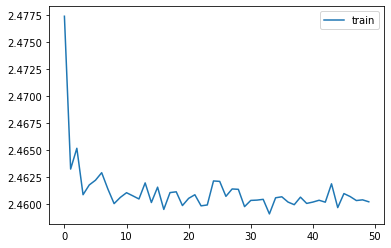

In [73]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

In [74]:
model.evaluate(x_input_test, y_input_test)

21/21 [==============================] - 0s 12ms/step - loss: 2.4650 - acc: 0.0614


[2.465009927749634, 0.06137724593281746]

In [85]:
y_pred = model.predict(x_input_test)

In [86]:
y_pred.shape

(668, 12)

In [87]:
print(x_input_test.shape)

nuemat=(x_input_test.transpose(2,0,1).reshape(3,-1)).T
print(nuemat.shape)

(668, 128, 3)
(85504, 3)


In [88]:
df = pd.DataFrame(y_pred)
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.088992,0.084802,0.091896,0.096347,0.080154,0.082764,0.088571,0.082302,0.098439,0.086092,0.08758,0.032061
1,0.088992,0.084802,0.091896,0.096347,0.080154,0.082764,0.088571,0.082302,0.098439,0.086092,0.08758,0.032061
2,0.088992,0.084802,0.091896,0.096347,0.080154,0.082764,0.088571,0.082302,0.098439,0.086092,0.08758,0.032061
3,0.088992,0.084802,0.091896,0.096347,0.080154,0.082764,0.088571,0.082302,0.098439,0.086092,0.08758,0.032061
4,0.088992,0.084802,0.091896,0.096347,0.080154,0.082764,0.088571,0.082302,0.098439,0.086092,0.08758,0.032061
...,...,...,...,...,...,...,...,...,...,...,...,...
663,0.088992,0.084802,0.091896,0.096347,0.080154,0.082764,0.088571,0.082302,0.098439,0.086092,0.08758,0.032061
664,0.088992,0.084802,0.091896,0.096347,0.080154,0.082764,0.088571,0.082302,0.098439,0.086092,0.08758,0.032061
665,0.088992,0.084802,0.091896,0.096347,0.080154,0.082764,0.088571,0.082302,0.098439,0.086092,0.08758,0.032061
666,0.088992,0.084802,0.091896,0.096347,0.080154,0.082764,0.088571,0.082302,0.098439,0.086092,0.08758,0.032061
